# Working with several networks

When one single network isn't enough.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib


---

**Prerequisites:**
- A Grid'5000 account
- A working EnOSlib environment and Jupyter (not included in EnOSlib dependencies, but `pip install jupyterlab` will install it)




## Setup

In [1]:
import enoslib as en

# get some logging info
import logging
logging.basicConfig(level=logging.INFO)

We reserve two nodes (with at least two network interfaces), the first network interface of each node will use the production network of Grid'5000 (not isolated network) while a second network interface will be configured to use a Vlan.

- To find out which machine have at least two network cards, you can refer to the [hardware page of Grid'5000](https://www.grid5000.fr/w/Hardware)
- To know more about Vlans on Grid'5000, you can refer to this [page](https://www.grid5000.fr/w/KaVLAN)

In [2]:
SITE = "rennes"

network = en.G5kNetworkConf(id="n1", type="prod", roles=["public"], site=SITE)
private = en.G5kNetworkConf(id="n2", type="kavlan", roles=["private"], site=SITE)

conf = (
    en.G5kConf.from_settings(job_name="enoslib_several_networks")
        .add_network_conf(network)
        .add_network_conf(private)
        .add_machine(
            roles=["server", "xp"],
            cluster="paravance",
            nodes=1,
            primary_network=network,
            secondary_networks=[private],
        )
        .add_machine(
            roles=["client", "xp"],
            cluster="paranoia",
            nodes=1,
            primary_network=network,
            secondary_networks=[private],
        )
        .finalize()
)
conf

Conf@0x7f63c06ebb10
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "enoslib_several_networks",
    "job_type": [
        "deploy"
    ],
    "key": "/home/msimonin/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "server",
                    "xp"
                ],
                "primary_network": "n1",
                "secondary_networks": [
                    "n2"
                ],
                "cluster": "paravance",
                "nodes": 1
            },
            {
                "roles": [
                    "client",
                    "xp"
                ],
                "primary_network": "n1",
                "secondary_networks": [
                    "n2"
                ],
                "cluster": "paranoia",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "n1",
                "type": "prod",
                "roles": [
                    "public"
                ],
                "site": "rennes"
            },
            {
                "id": "n2",
                "type": "kavlan",
                "roles": [
                    "private"
                ],
                "site": "rennes"
            }
        ]
    }
}

In [3]:
provider = en.G5k(conf)
roles, networks = provider.init()
roles

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading 1816602 from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Waiting for 1816602 on rennes [2021-08-30 13:39:22]
INFO:enoslib.infra.enos_g5k.g5k_api_utils:All jobs are Running !


{'server': [Host(address='paravance-44.rennes.grid5000.fr', alias='paravance-44.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'xp': [Host(address='paravance-44.rennes.grid5000.fr', alias='paravance-44.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='paranoia-6.rennes.grid5000.fr', alias='paranoia-6.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'client': [Host(address='paranoia-6.rennes.grid5000.fr', alias='paranoia-6.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

## Get the network information of your nodes

First we retrieve the network information by syncing the Host descriptions with the remote machines.
Syncing the information will populate every single Host datastructure with some actual information (e.g. number of cores, network information).
This relies on Ansible fact gathering and is provider agnostic. 
Note that Grid'5000 provides a lot of node information in its [REST API](https://api.grid5000.fr) (but provide only static information)

In [4]:
roles = en.sync_info(roles, networks)
roles

[WARNING]: No inventory was parsed, only implicit localhost is available



PLAY [all] ************************************************************************************************************************************************

TASK [hostname] *******************************************************************************************************************************************
 [started TASK: hostname on paravance-44.rennes.grid5000.fr]
 [started TASK: hostname on paranoia-6.rennes.grid5000.fr]
changed: [paravance-44.rennes.grid5000.fr]
changed: [paranoia-6.rennes.grid5000.fr]

PLAY [Gather facts for all hosts] *************************************************************************************************************************

TASK [Gathering Facts] ************************************************************************************************************************************
ok: [paravance-44.rennes.grid5000.fr]
ok: [paranoia-6.rennes.grid5000.fr]

TASK [setup] ********************************************************************************

ip
::1/128
127.0.0.1/8
ip
fe80::eef4:bbff:fed0:eb52/64
10.24.6.44/18
ip
172.16.96.44/20
fe80::eef4:bbff:fed0:eb50/64
ip
::1/128


We can now filter the network addresses of the nodes given a network

In [5]:
server = roles["server"][0]
server.filter_addresses(networks=networks["private"])

[IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosVlan4Network object at 0x7f63bfdceb10>, ip=IPv4Interface('10.24.6.44/18'))]

In [6]:
ip_address = server.filter_addresses(networks=networks["private"])[0]
str(ip_address.ip.ip)

'10.24.6.44'

In [7]:
server.filter_addresses(networks=networks["public"])

[IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd4Network object at 0x7f63c06d7850>, ip=IPv4Interface('172.16.96.44/20'))]

## A simple load generation tool

We are using [flent](https://flent.org/), a convenient client to netperf that is able to play different network benchmarks.

Roughly speaking, Flent connects to a Netperf server, starts a benchmark and collect metrics in various format (csv, images ... ).
That makes a good candidates when you need to get a quick insight into the performance of the network between your nodes

The goal of this part is to initiate a benchmark of TCP traffic on the `private` network. So we need to instruct `flent` to connect to the `netperf` server on the relevant address.

In [8]:
with en.actions(roles=roles) as a:
    a.apt_repository(
        repo="deb http://deb.debian.org/debian stretch main contrib non-free",
        state="present",
    )
    a.apt(
        name=["flent", "netperf", "python3-setuptools", "python3-matplotlib"],
        state="present",
    )


PLAY [all] ************************************************************************************************************************************************

TASK [apt_repository] *************************************************************************************************************************************
 [started TASK: apt_repository on paravance-44.rennes.grid5000.fr]
 [started TASK: apt_repository on paranoia-6.rennes.grid5000.fr]
ok: [paravance-44.rennes.grid5000.fr]
ok: [paranoia-6.rennes.grid5000.fr]

TASK [apt] ************************************************************************************************************************************************
 [started TASK: apt on paravance-44.rennes.grid5000.fr]
 [started TASK: apt on paranoia-6.rennes.grid5000.fr]
ok: [paranoia-6.rennes.grid5000.fr]
ok: [paravance-44.rennes.grid5000.fr]


---
Checking the routes on the nodes. Make sure the `private` network goes through the `private` interface.

In [9]:
routes = en.run_command("ip route list", roles=roles)
print("\n-Routes-\n")
print("\n\n".join([f"{r.host} => {r.stdout}" for r in routes]))


PLAY [all] ************************************************************************************************************************************************

TASK [ip route list] **************************************************************************************************************************************
 [started TASK: ip route list on paravance-44.rennes.grid5000.fr]
 [started TASK: ip route list on paranoia-6.rennes.grid5000.fr]
changed: [paravance-44.rennes.grid5000.fr]
changed: [paranoia-6.rennes.grid5000.fr]

-Routes-

paravance-44.rennes.grid5000.fr => default via 172.16.111.254 dev eno1 
10.24.0.0/18 dev eno2 proto kernel scope link src 10.24.6.44 
172.16.96.0/20 dev eno1 proto kernel scope link src 172.16.96.44 

paranoia-6.rennes.grid5000.fr => default via 172.16.111.254 dev enp3s0f0 
10.24.0.0/18 dev enp3s0f1 proto kernel scope link src 10.24.4.6 
172.16.96.0/20 dev enp3s0f0 proto kernel scope link src 172.16.100.6 


In [10]:
server_address = str(server.filter_addresses(networks=networks["private"])[0].ip.ip)

with en.actions(pattern_hosts="server", roles=roles) as a:
    a.shell("netperf", background=True) # this is somehow idempotent .. will fail silently if netperf is already started
    a.wait_for(port=12865, state="started", task_name="Waiting for netperf to be ready")
    

with en.actions(pattern_hosts="client", roles=roles) as a:
    a.shell(
        " flent tcp_upload -p totals "
        " -l 60 "
        f" -H { server_address } "
        " -t 'tcp_upload test' "
        " -o result.png"
    )
    a.fetch(src="result.png", dest="result")


PLAY [server] *********************************************************************************************************************************************

TASK [netperf] ********************************************************************************************************************************************
 [started TASK: netperf on paravance-44.rennes.grid5000.fr]
changed: [paravance-44.rennes.grid5000.fr]

TASK [Waiting for netperf to be ready] ********************************************************************************************************************
 [started TASK: Waiting for netperf to be ready on paravance-44.rennes.grid5000.fr]
ok: [paravance-44.rennes.grid5000.fr]

PLAY [client] *********************************************************************************************************************************************

TASK [flent tcp_upload -p totals  -l 60  -H 10.24.6.44  -t 'tcp_upload test'  -o result.png] *****************************************************

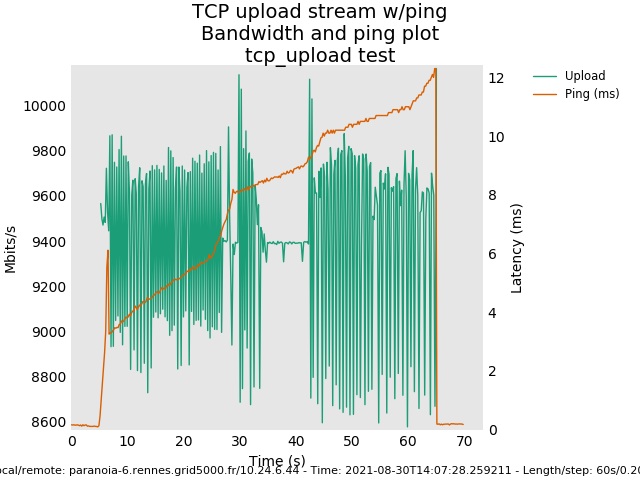

In [11]:
from IPython.display import Image
Image(f"result/{roles['client'][0].alias}/result.png")

---
Forcing the flent client to be bound on the right network (not really necessary if the routes are set correctly).
It's an opportunity to use host variables so let's do it ;)

`flent` has an option for this `--local-bind <ip>`

In [12]:
for h in roles["client"]:
    h.extra.update({"local_bind": h.filter_addresses(networks=networks["private"])[0].ip.ip})
roles["client"][0]

ip
fe80::a236:9fff:fe28:a7b4/64
172.16.100.6/20
ip
::1/128
127.0.0.1/8
ip
10.24.4.6/18
fe80::a236:9fff:fe28:a7b6/64


In [13]:
server_address = str(server.filter_addresses(networks=networks["private"])[0].ip.ip)

with en.actions(pattern_hosts="server", roles=roles) as a:
    a.shell("netperf", background=True) # this is somehow idempotent .. will fail silently if netperf is already started
    a.wait_for(port=12865, state="started", task_name="Waiting for netperf to be ready")
    

with en.actions(pattern_hosts="client", roles=roles) as a:
    a.shell(
        " flent tcp_upload -p totals "
        " -l 60 "
        f" -H { server_address } "
        "--local-bind {{ local_bind }} "
        " -t 'tcp_upload test' "
        " -o result_bind.png"
    )
    a.fetch(src="result_bind.png", dest="result")


PLAY [server] *********************************************************************************************************************************************

TASK [netperf] ********************************************************************************************************************************************
 [started TASK: netperf on paravance-44.rennes.grid5000.fr]
changed: [paravance-44.rennes.grid5000.fr]

TASK [Waiting for netperf to be ready] ********************************************************************************************************************
 [started TASK: Waiting for netperf to be ready on paravance-44.rennes.grid5000.fr]
ok: [paravance-44.rennes.grid5000.fr]

PLAY [client] *********************************************************************************************************************************************

TASK [flent tcp_upload -p totals  -l 60  -H 10.24.6.44 --local-bind 10.24.4.6  -t 'tcp_upload test'  -o result_bind.png] *************************

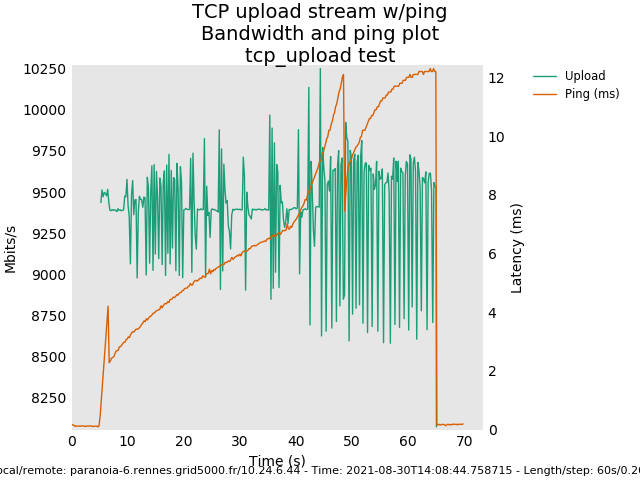

In [14]:
from IPython.display import Image
Image(f"result/{roles['client'][0].alias}/result_bind.png")

## Emulating the network conditions

We'll illustrate how network constraints can be set on specific network interfaces on the nodes of the experiment.
To do so EnOSlib provides two services:
- the Netem service which is a wrapper around [netem](https://wiki.linuxfoundation.org/networking/netem).
- the NetemHTB which provides a high level interface to finer grained [HTB network based emulation](https://tldp.org/HOWTO/Traffic-Control-HOWTO/classful-qdiscs.html)

More information can be found in the EnOSlib documentation:  https://discovery.gitlabpages.inria.fr/enoslib/apidoc/netem.

EnOSlib let's you set the constraint easily on a dedicated network by only specifying it with its logical name.

In [15]:
netem = en.Netem()
# symetric constraints:
# node1|10ms ---> 10ms|node2|10ms --> 10ms|node1
netem.add_constraints("delay 10ms", roles["xp"], symetric=True, networks=networks["private"])

device,direction,options
eno2,in,delay 10ms
eno2,out,delay 10ms
device,direction,options
enp3s0f1,in,delay 10ms
enp3s0f1,out,delay 10ms


In [16]:
netem.deploy()


PLAY [all] ************************************************************************************************************************************************

TASK [Applying the network constraints] *******************************************************************************************************************
 [started TASK: Applying the network constraints on paravance-44.rennes.grid5000.fr]
 [started TASK: Applying the network constraints on paranoia-6.rennes.grid5000.fr]
changed: [paranoia-6.rennes.grid5000.fr] => (item=tc qdisc del dev enp3s0f1 root || true ; tc qdisc del dev enp3s0f1 root || true ; tc qdisc del dev ifb1 root ; tc qdisc add dev enp3s0f1 root netem delay 10ms ; tc qdisc add dev enp3s0f1 ingress ; ip link add ifb1 type ifb ; ip link set dev ifb1 up ; tc filter add dev enp3s0f1 parent ffff: protocol ip u32 match u32 0 0 flowid 1:1 action mirred egress redirect dev ifb1 ; tc qdisc add dev ifb1 root netem delay 10ms)
changed: [paravance-44.rennes.grid5000.fr] => (ite

---
There's a convenient method that let you quickly check the network condition (at least the RTT latency)

In [18]:
from pathlib import Path
print(Path(f"_tmp_enos_/{roles['client'][0].alias}.out").read_text())
print("----")
print(Path(f"_tmp_enos_/{roles['client'][0].alias}.out").read_text())

10.24.6.44   : 40.34 40.37 40.41 40.41 40.38 40.40 40.37 40.36 40.39 40.39
172.16.100.6 : 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
172.16.96.44 : 0.16 0.13 0.10 0.12 0.12 0.13 0.11 0.11 0.11 0.12
10.24.4.6    : 0.04 0.03 0.01 0.01 0.03 0.03 0.03 0.02 0.03 0.03

       4 targets
       4 alive
       0 unreachable
       0 unknown addresses

       0 timeouts (waiting for response)
      40 ICMP Echos sent
      40 ICMP Echo Replies received
       0 other ICMP received

 0.01 ms (min round trip time)
 10.1 ms (avg round trip time)
 40.4 ms (max round trip time)
        9.041 sec (elapsed real time)


----
10.24.6.44   : 40.34 40.37 40.41 40.41 40.38 40.40 40.37 40.36 40.39 40.39
172.16.100.6 : 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
172.16.96.44 : 0.16 0.13 0.10 0.12 0.12 0.13 0.11 0.11 0.11 0.12
10.24.4.6    : 0.04 0.03 0.01 0.01 0.03 0.03 0.03 0.02 0.03 0.03

       4 targets
       4 alive
       0 unreachable
       0 unknown addresses

       0 timeouts (waiting

In [17]:
netem.validate()


PLAY [Gather facts for all hosts] *************************************************************************************************************************

TASK [Gathering Facts] ************************************************************************************************************************************
ok: [paravance-44.rennes.grid5000.fr]
ok: [paranoia-6.rennes.grid5000.fr]

TASK [setup] **********************************************************************************************************************************************
ok: [paranoia-6.rennes.grid5000.fr]
ok: [paravance-44.rennes.grid5000.fr]

PLAY [Utils functions] ************************************************************************************************************************************

TASK [Gathering Facts] ************************************************************************************************************************************
ok: [paravance-44.rennes.grid5000.fr]
ok: [paranoia-6.rennes.grid50

## Clean

In [19]:
provider.destroy()

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading 1816602 from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Killing the job (rennes, 1816602)
